# Monte-Car-ELO

Monte-Carlo experimentation for simulating the osu!mania competition with the ranked maps

## Experimentation Description

We assume the system where there is actually an ELO system for the osu!mania, but they can be gained from competing between two players in some ranked maps. The chance of winning is evaluated by the average of how likely a player will win in a rice pick, and how likely a player will win in an LN pick.

The dataset is uploaded in #skillbans it is the ranked scores available after 1st January 2020, feel free to play with the notebook and/or feel free to try to help with the efficiency of the code and the idea of the development for skillbans!

## Loading the Datasets

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_parquet('dataset/scores.parquet')
beatmaps = pd.read_parquet('dataset/beatmaps.parquet')
ranks = pd.read_parquet('dataset/pp_4k.parquet')

In [3]:
pivot = dataset.pivot(index='beatmap_id', columns='user_id', values='score')

In [4]:
users = pivot.columns
beatmap_ids = pivot.index

In [5]:
ranks = ranks[ranks['user_id'].isin(users)].sort_values(by='pp', ascending=False)

In [6]:
beatmaps['RC_ratio'] = beatmaps['RC'] / (beatmaps['RC'] + beatmaps['LN'])
beatmaps['LN_ratio'] = 1 - beatmaps['RC_ratio']

In [7]:
beatmaps

,beatmap_id,RC,LN,SR,RC_ratio,LN_ratio
0,222593,1822,56,5.15772,0.970181,0.029819
1,257524,1095,56,4.04798,0.951347,0.048653
2,259067,1876,26,5.35516,0.986330,0.013670
3,285623,1172,179,4.91066,0.867506,0.132494
4,309584,1253,60,4.15686,0.954303,0.045697
...,...,...,...,...,...,...
3091,4123096,2765,118,4.84020,0.959070,0.040930
3092,4127707,1215,197,4.18491,0.860482,0.139518
3093,4138640,849,206,4.22209,0.804739,0.195261
3094,4144315,2005,199,5.45803,0.909710,0.090290


## Random samples

Here, it is still necessary due to the time complexity of the code, which is really hard to optimize (approx 3 minutes for 210 players)

In [8]:
normal_pop = ranks.tail(len(users) - 1000)['user_id'].values
outlier_pop = ranks.head(1000)['user_id'].values

In [9]:
import numpy as np
from numpy.random import choice

In [10]:
normal_samples = choice(normal_pop, 200, replace=False)
outlier_samples = choice(outlier_pop, 10, replace=False)
all_samples = np.concatenate((normal_samples, outlier_samples))

In [11]:
outlier_samples

array([15584916, 23643731, 30115846, 23989702, 22645272, 29657458,
       25682415, 15806513,  5604329, 19360101], dtype=int64)

### Calculating winning chances

For calculating the winning chance, we need to normalize the winning chance depending on the ratio of rice and LN to obtain the winning chance in each skillset, then we average it to simulate the ideal tournament situation where Rice pick == LN pick

In [14]:
def calculate_winning_chance(player1, player2):
    scores = pivot[[player1, player2]].dropna(how='any').reset_index()
    if not scores.shape[0]:
        return np.nan
    scores = scores.merge(beatmaps, how='left')[[player1, player2, 'RC_ratio', 'LN_ratio']]
    scores['win'] = (scores[player1] > scores[player2]).astype(int) + 0.5 * (scores[player1] == scores[player2]).astype(int)
    total_rice = scores['RC_ratio'].sum()
    total_ln = scores['LN_ratio'].sum()
    total_score = 0
    div = 0
    if total_rice > 0:
        total_score += (scores['win'] * scores['RC_ratio']).sum() / total_rice
        div += 1
    if total_ln > 0:
        total_score += (scores['win'] * scores['LN_ratio']).sum() / total_ln
        div += 1
    return total_score / div

TODO: mat[i,j] is actually 1 - mat[j,i]

If I can fix this part, everything will run 2x faster

In [15]:
mat = np.zeros((len(all_samples), len(all_samples)))

for i, player1 in enumerate(all_samples):
    for j, player2 in enumerate(all_samples):
        if i == j: 
            mat[i,j] = 0.5
            continue
        chance = calculate_winning_chance(player1, player2)
        mat[i, j] = chance

In [16]:
winning_chances = pd.DataFrame(mat, index=all_samples, columns=all_samples)

In [17]:
winning_chances

,16500465,17768545,16009973,9531864,14926444,6879648,4716766,4519407,26371501,13995992,...,15584916,23643731,30115846,23989702,22645272,29657458,25682415,15806513,5604329,19360101
16500465,0.500000,0.205628,0.889498,0.737653,0.199800,0.394242,0.538374,0.832744,0.794032,1.000000,...,0.272957,0.342150,0.241611,0.000000,0.136961,0.081948,0.175298,0.164318,0.028340,0.104414
17768545,0.794372,0.500000,0.964324,0.906939,0.480753,0.734437,0.810577,0.962077,0.899470,0.819291,...,0.663684,0.589838,0.573365,0.285850,0.499684,0.471877,0.496023,0.335678,0.241684,0.418793
16009973,0.110502,0.035676,0.500000,0.489117,0.141260,0.179163,0.313210,0.395557,0.360935,0.000000,...,0.172528,0.194260,0.023769,0.000000,0.099798,0.016318,0.101185,0.047357,0.000000,0.062471
9531864,0.262347,0.093061,0.510883,0.500000,0.129260,0.075760,0.000000,0.305756,0.290701,NaN,...,0.236799,0.357344,0.000000,0.127308,0.157907,0.000000,0.000000,0.032860,0.000000,0.134509
14926444,0.800200,0.519247,0.858740,0.870740,0.500000,0.719597,0.802342,0.870785,0.833187,0.813625,...,0.682076,0.562870,0.558771,0.259210,0.642893,0.637584,0.516087,0.302300,0.246918,0.428414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29657458,0.918052,0.528123,0.983682,1.000000,0.362416,0.832052,0.918845,0.986263,0.934345,1.000000,...,0.567876,0.513372,0.658699,0.272361,0.476710,0.500000,0.564209,0.221589,0.203972,0.429053
25682415,0.824702,0.503977,0.898815,1.000000,0.483913,0.754913,0.862076,0.937391,0.967041,NaN,...,0.485582,0.450877,0.393243,0.353560,0.492108,0.435791,0.500000,0.268622,0.237336,0.402461
15806513,0.835682,0.664322,0.952643,0.967140,0.697700,0.883337,1.000000,0.929984,0.894449,1.000000,...,0.768397,0.750037,0.809096,0.858941,0.745694,0.778411,0.731378,0.500000,0.670476,0.728941
5604329,0.971660,0.758316,1.000000,1.000000,0.753082,0.932346,0.973234,1.000000,0.988794,1.000000,...,0.882996,0.751892,0.790105,0.452159,0.731914,0.796028,0.762664,0.329524,0.500000,0.724826


## Monte Carlo

We then try to simulate the competition with an ELO system, by using the winning chances as an actual outcome

In [28]:
def monte_car_elo(winning_matrix, n_matchups=10000, expected_elo=0, multipiler=0.01):
    i = 0
    list_players = np.array(winning_matrix.index)
    elos = pd.DataFrame(np.ones((1, len(list_players))) * expected_elo, columns=list_players, index=['elo'])
    while i < n_matchups:
        player1, player2 = choice(list_players, 2, replace=False)
        ra = float(elos[player1])
        rb = float(elos[player2])
        if pd.isna(winning_matrix.loc[player1, player2]):
            continue
        expected_outcome1 = 1 / (1 + 10**((ra - rb) / 400))
        expected_outcome2 = 1 / (1 + 10**((rb - ra) / 400))
        actual_outcome1 = winning_matrix.loc[player1, player2]
        actual_outcome2 = winning_matrix.loc[player2, player1]
        elos[player1] += multipiler * (actual_outcome1 - expected_outcome1)
        elos[player2] += multipiler * (actual_outcome2 - expected_outcome2)
        i += 1
    return elos.T

In [29]:
elo = monte_car_elo(winning_chances, n_matchups=100000).sort_values(by='elo', ascending=False)

C:\Users\Tanaphoom\AppData\Local\Temp\ipykernel_3720\1213295750.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ra = float(elos[player1])
C:\Users\Tanaphoom\AppData\Local\Temp\ipykernel_3720\1213295750.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rb = float(elos[player2])


In [30]:
import matplotlib.pyplot as plt

In [31]:
user_elos = elo.reset_index().rename({'index': 'user_id'}, axis=1)

(array([2., 0., 0., 1., 1., 2., 0., 1., 2., 1.]),
 array([1.70714265, 1.95754893, 2.20795522, 2.4583615 , 2.70876779,
        2.95917407, 3.20958036, 3.45998664, 3.71039293, 3.96079921,
        4.2112055 ]),
 <BarContainer object of 10 artists>)

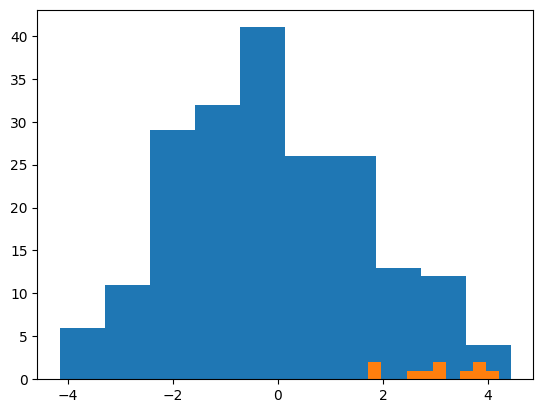

In [32]:
plt.hist(user_elos[user_elos['user_id'].isin(normal_samples)]['elo'])
plt.hist(user_elos[user_elos['user_id'].isin(outlier_samples)]['elo'])

In [33]:
elo.sort_values(by='elo', ascending=False)

,elo
9817140,4.434009
15430792,4.243271
5604329,4.211205
23989702,3.817347
15806513,3.736998
...,...
17640839,-3.467721
23000417,-3.519180
8934725,-3.618508
25136151,-3.996006
